In [1]:
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *
from libs.convex_hull import *

from mplsoccer import Pitch
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

In [2]:
df = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
df = extract_one_match(df,1)


In [3]:
hulls = convex_hull(df.iloc[::48], "^home", num_players = 11)

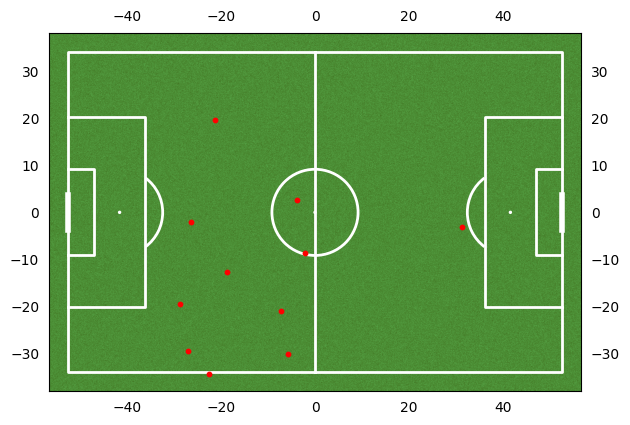

In [4]:
top_10_hulls = top_n_similar_hulls(hulls[150], hulls,100)

football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
football_pitch.draw()  # Draw the pitch on the current axis

plt.scatter(hulls[150].points[:, 0], hulls[150].points[:, 1], color='red', s=10)
plt.show()


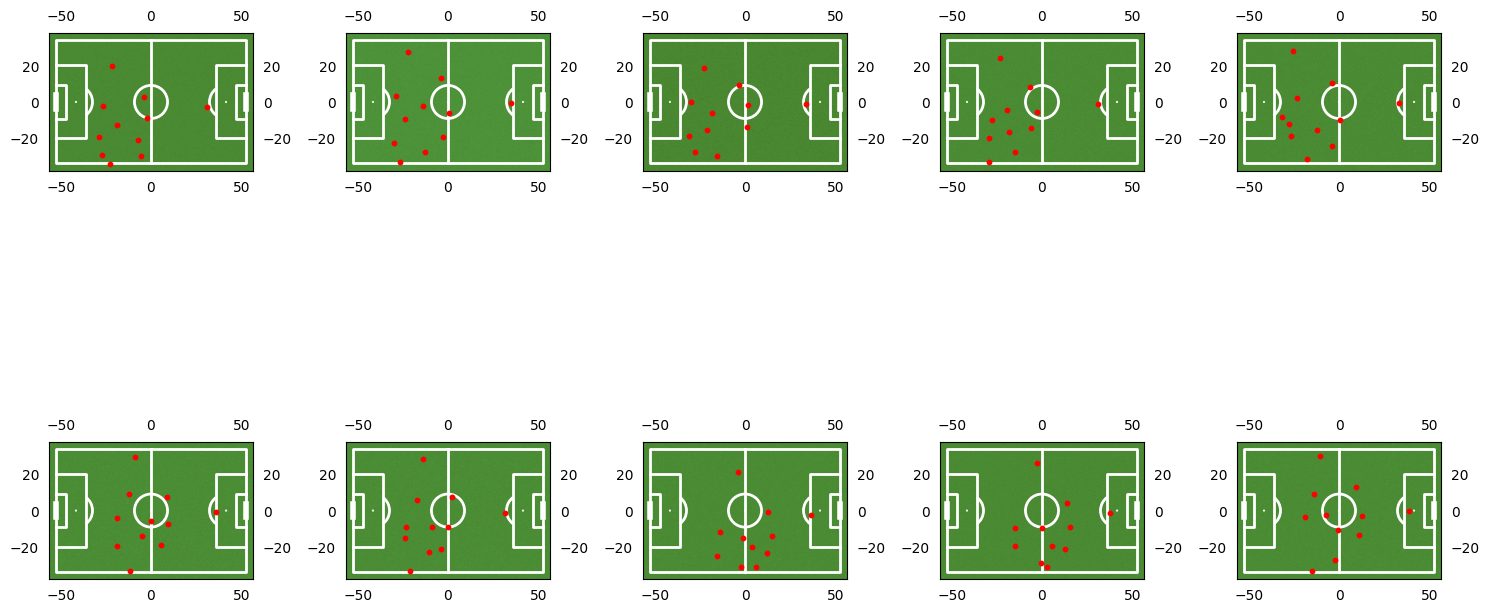

In [5]:

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Create the pitch with the desired settings
for hull, i in zip(top_10_hulls[:10], range(len(top_10_hulls[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    # Scatter plot for convex hull points
    ax[row, col].scatter(hull[0].points[:, 0], hull[0].points[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()



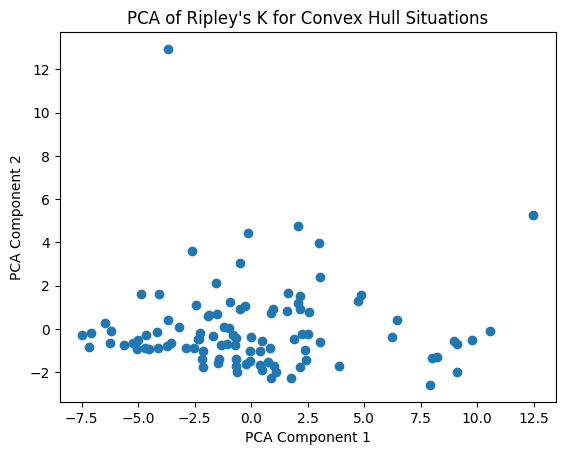

In [6]:
# Calculate Ripley's K values for the convex hull situations
ripley_k_vals_hulls = ripley_k_for_hulls(top_10_hulls)

# Perform PCA on the Ripley's K values from the convex hull situations
pca_obj_ripley_hulls = PCAObject(ripley_k_vals_hulls, 10)  # Fit PCA with 10 components
np_pca_ripley_hulls = pca_obj_ripley_hulls.transform(ripley_k_vals_hulls)

# Step 9: Plot the PCA-reduced Ripley's K values for the convex hulls
plt.figure()
plt.scatter(np_pca_ripley_hulls[:, 0], np_pca_ripley_hulls[:, 1])
plt.title("PCA of Ripley's K for Convex Hull Situations")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


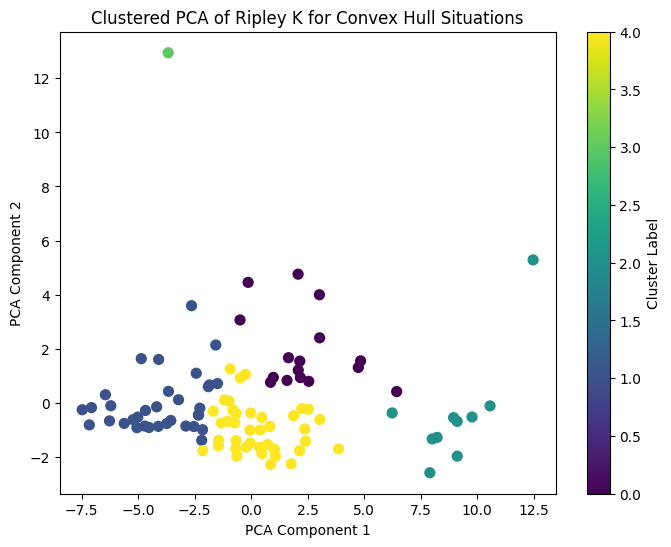

In [7]:
# Step 4: Cluster the PCA-reduced Ripley's K values using your KMeansObject
n_clusters = 5  # Choose the number of clusters
clustering_obj_ripley_hulls = KMeansObject(np_pca_ripley_hulls, n_clusters)  # Fit KMeans
labels = clustering_obj_ripley_hulls.get_labels()  # Get the cluster labels

# Step 5: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley_hulls[:, 0], np_pca_ripley_hulls[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clustered PCA of Ripley K for Convex Hull Situations')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')  # Optional: Add a colorbar to indicate cluster labels
plt.show()


In [8]:
top_10_hulls[0][0].points

array([[ -2.14063573,  -8.63452435],
       [-21.302351  ,  19.69060898],
       [ 31.22801208,  -3.04926443],
       [-26.8713131 , -29.47746277],
       [ -7.17757082, -20.97961426],
       [ -3.85489535,   2.54097867],
       [-26.36822701,  -2.04336047],
       [-18.62288094, -12.73161221],
       [-28.70673943, -19.53525162],
       [-22.56090927, -34.38471222],
       [ -5.74419737, -30.0919838 ]])

In [16]:
# Create the main directory for clusters
main_folder = "clusters"
os.makedirs(main_folder, exist_ok=True)


# Assuming you have a DataFrame or similar structure that relates each hull to its original data
# For example, top_10_hulls should be indexed or associated with their respective K values.

# Create a dictionary to hold situations by cluster
situations_by_cluster = {i: [] for i in range(n_clusters)}

# Map each situation (hull) to its corresponding cluster label
for idx, label in enumerate(labels):
 
    situations_by_cluster[label].append(top_10_hulls[idx][0].points)  # Append the hull or associated data to the respective cluster


# Assuming you have a dictionary `situations_by_cluster` where each cluster contains multiple situations (hulls)
for cluster, situations in situations_by_cluster.items():
    # Create a subfolder for each cluster
    cluster_folder = os.path.join(main_folder, f"cluster_{cluster}")
    os.makedirs(cluster_folder, exist_ok=True)
    
    # Loop through each situation in the cluster and plot it
    for idx, situation in enumerate(situations):
        # Create a new figure with a soccer pitch background
        fig, ax = plt.subplots(figsize=(10, 7))
        football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                               label=True, line_color="white", pitch_color="grass")
        football_pitch.draw(ax=ax)
        
        # Scatter plot for the convex hull points
        ax.scatter(situation[:, 0], situation[:, 1], color='red', s=50)
        
        # Compute the convex hull for the points
        hull = ConvexHull(situation)
        # Extract the vertices of the hull
        hull_points = situation[hull.vertices]
        
        # Plot the convex hull polygon
        polygon = Polygon(hull_points, closed=True, edgecolor='blue', fill=False, linewidth=2)
        ax.add_patch(polygon)
        
        # Customize the plot (optional)
        plt.title(f'Situation {idx+1} in Cluster {cluster}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        
        # Save the plot in the appropriate cluster folder
        save_path = os.path.join(cluster_folder, f'situation_{idx+1}.png')
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid displaying it
